In [1]:
import pandas as pd
from TrajectoryClusteringAnalysis.tca import TCA

## Preprocessing data

In [ ]:
df = pd.read_csv('../data/dataframe_test.csv')
df.head()

,id,month,care_status,sex,age,education,wealth,distance_clinic
0,3,0.0,D,1.0,1.0,2.0,2.0,1.0
1,3,1.0,D,1.0,1.0,2.0,2.0,1.0
2,3,2.0,D,1.0,1.0,2.0,2.0,1.0
3,3,3.0,D,1.0,1.0,2.0,2.0,1.0
4,3,4.0,D,1.0,1.0,2.0,2.0,1.0


In [9]:
# Sélectionner les colonnes pertinentes pour l'analyse
selected_cols = df[['id', 'month', 'care_status']]
# Créer un tableau croisé des données en format large
#       -> Chaque individu est sur une ligne.
#       -> Les mesures dans le temps (Temps1, Temps2, Temps3) sont des colonnes distinctes.
pivoted_data = selected_cols.pivot(index='id', columns='month', values='care_status')
pivoted_data['id'] = pivoted_data.index
pivoted_data = pivoted_data[['id'] + [col for col in pivoted_data.columns if col != 'id']]
# Renommer les colonnes avec un préfixe "month_"
pivoted_data.columns = ['id'] + ['month_' + str(int(col)+1) for col in pivoted_data.columns[1:]]
# Sélectionner un échantillon aléatoire de 10% des données
pivoted_data_random_sample = pivoted_data.sample(frac=0.1, random_state=42).reset_index(drop=True)

In [5]:
# Filter individuals observed for at least 18 months
valid_18months_individuals = pivoted_data.dropna(thresh=19).reset_index(drop=True)
# Select only the first 18 months for analysis
valid_18months_individuals = valid_18months_individuals[['id'] + [f'month_{i}' for i in range(1, 19)]]
# Sélectionner un échantillon aléatoire de 10% des données
valid_18months_individuals_sample = valid_18months_individuals.sample(frac=0.1, random_state=42).reset_index(drop=True)

## Initialisation du Package

In [10]:
tca = TCA(data=pivoted_data_random_sample,
              id='id',
              alphabet=['D', 'C', 'T', 'S'],
              states=["diagnostiqué", "en soins", "sous traitement", "inf. contrôlée"])

INFO:root:TCA object initialized successfully


Dataset :
data shape:  (293, 52)
state coding:
   alphabet            label  label encoded
0        D     diagnostiqué              1
1        C         en soins              2
2        T  sous traitement              3
3        S   inf. contrôlée              4


## Distance Hamming

In [11]:
distance_matrix = tca.compute_distance_matrix(metric='hamming', substitution_cost_matrix=None)
print("distance matrix :\n",distance_matrix)

INFO:root:Calculating distance matrix using metric: hamming...
c:\users\ndiaga.dieng\documents\trajectoryclusteringanalysis\TrajectoryClusteringAnalysis\tca.py:188: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.distance_matrix = np.array(pdist(self.data.replace(self.label_to_encoded), metric=metric))
INFO:root:Time taken for computation: 0.02 seconds


distance matrix :
 [0.76923077 0.82692308 0.75       ... 0.88461538 0.98076923 0.98076923]


INFO:root:Computing the linkage matrix using method: ward...
c:\users\ndiaga.dieng\documents\trajectoryclusteringanalysis\TrajectoryClusteringAnalysis\tca.py:283: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(condensed_distance_matrix, method=method, optimal_ordering=optimal_ordering)
INFO:root:Linkage matrix computed successfully


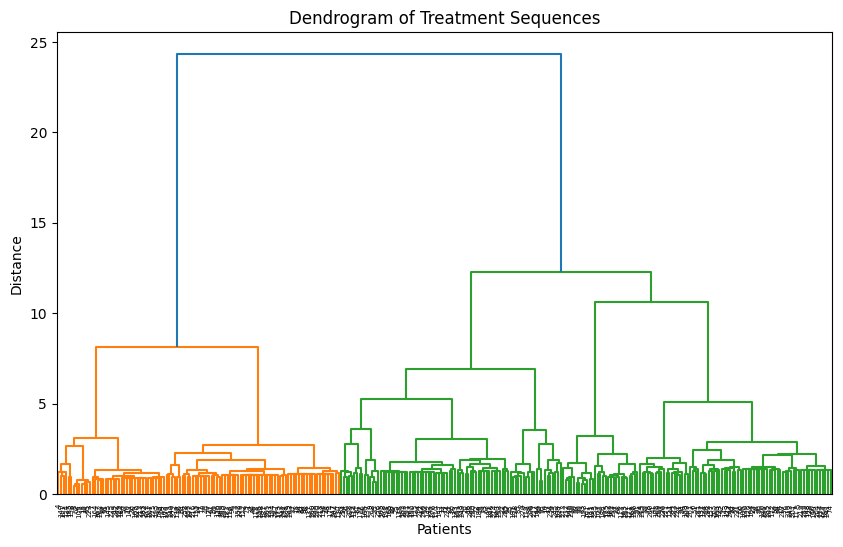

In [12]:
linkage_matrix = tca.hierarchical_clustering(distance_matrix)
tca.plot_dendrogram(linkage_matrix)

### plot heatmap with distance hamming

c:\users\ndiaga.dieng\documents\trajectoryclusteringanalysis\TrajectoryClusteringAnalysis\tca.py:342: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.clustermap(self.data.drop(self.id, axis=1).replace(self.label_to_encoded),


<Figure size 800x800 with 0 Axes>

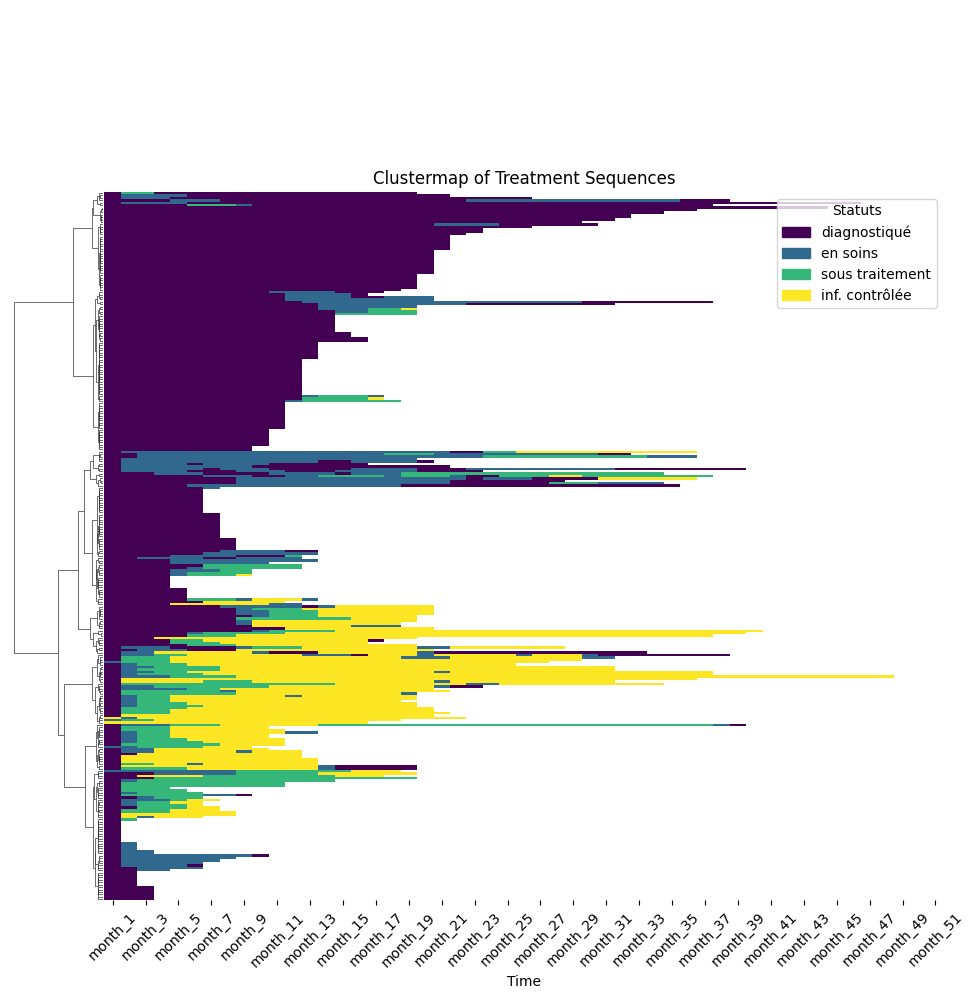

In [13]:
tca.plot_clustermap(linkage_matrix)

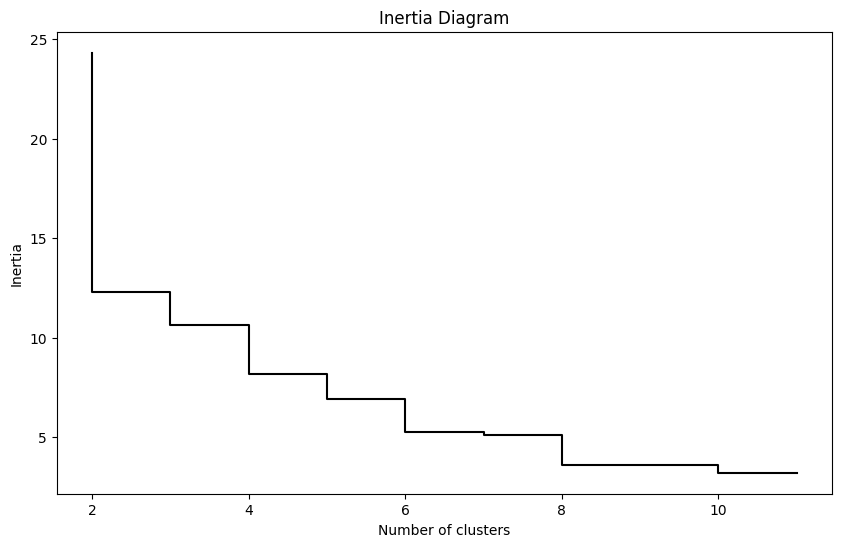

In [14]:
tca.plot_inertia(linkage_matrix)

heights:  [21.400000000000002, 16.8, 5.800000000000001, 14.600000000000001]


c:\users\ndiaga.dieng\documents\trajectoryclusteringanalysis\TrajectoryClusteringAnalysis\tca.py:435: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(cluster_df[1].drop(self.id, axis=1).replace(self.label_to_encoded), cmap=self.colors, cbar=False, ax=ax, yticklabels=False)
c:\users\ndiaga.dieng\documents\trajectoryclusteringanalysis\TrajectoryClusteringAnalysis\tca.py:435: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(cluster_df[1].drop(self.id, axis=1).replace(self.label_to_encoded), cmap=self.colors, cbar=F

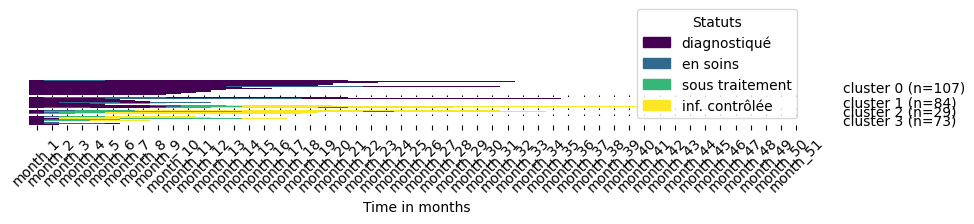

In [15]:
clusters = tca.assign_clusters(linkage_matrix, num_clusters=4)
    
tca.plot_cluster_heatmaps(clusters, sorted=False)

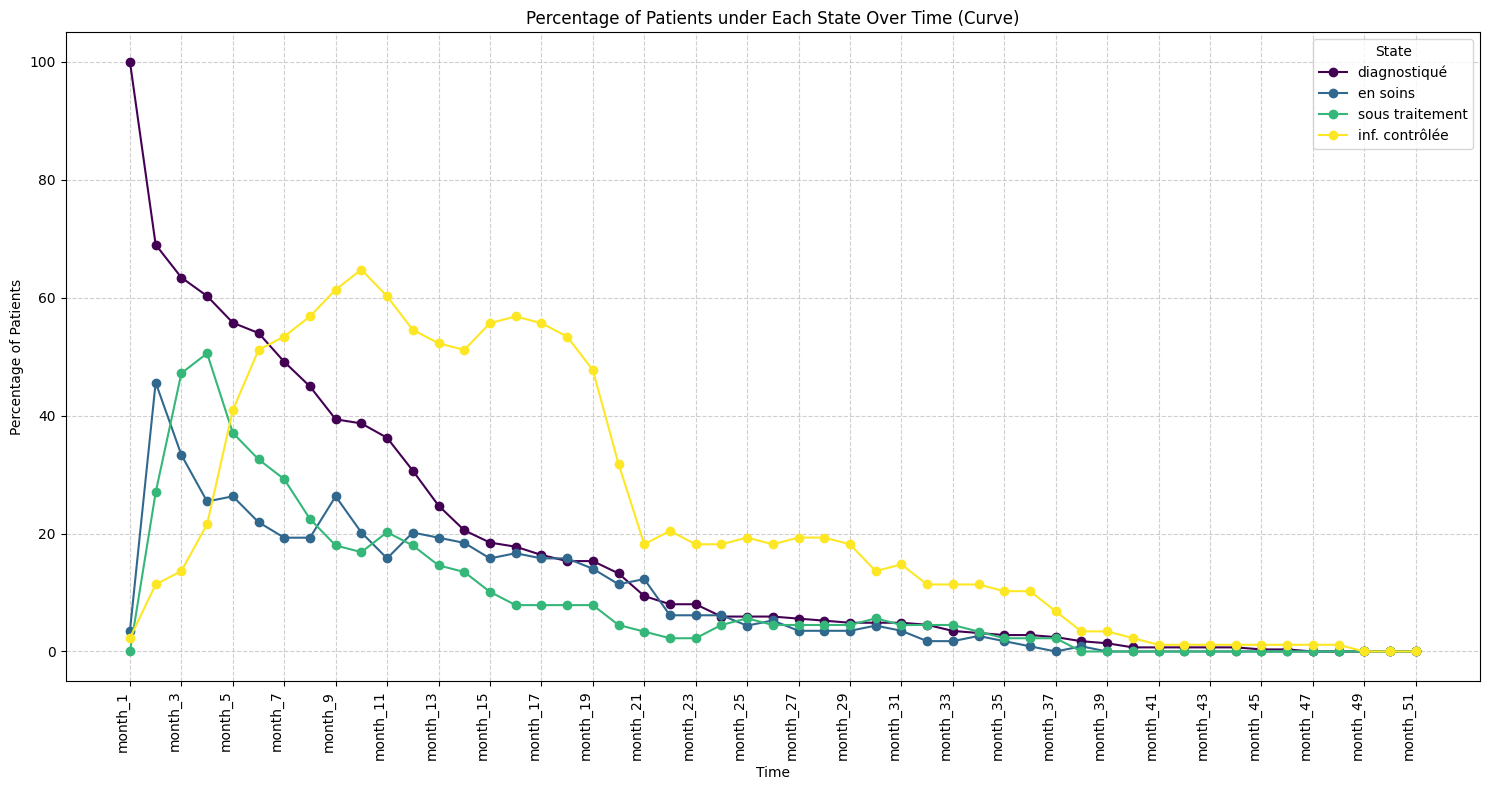

In [16]:
tca.plot_treatment_percentage()

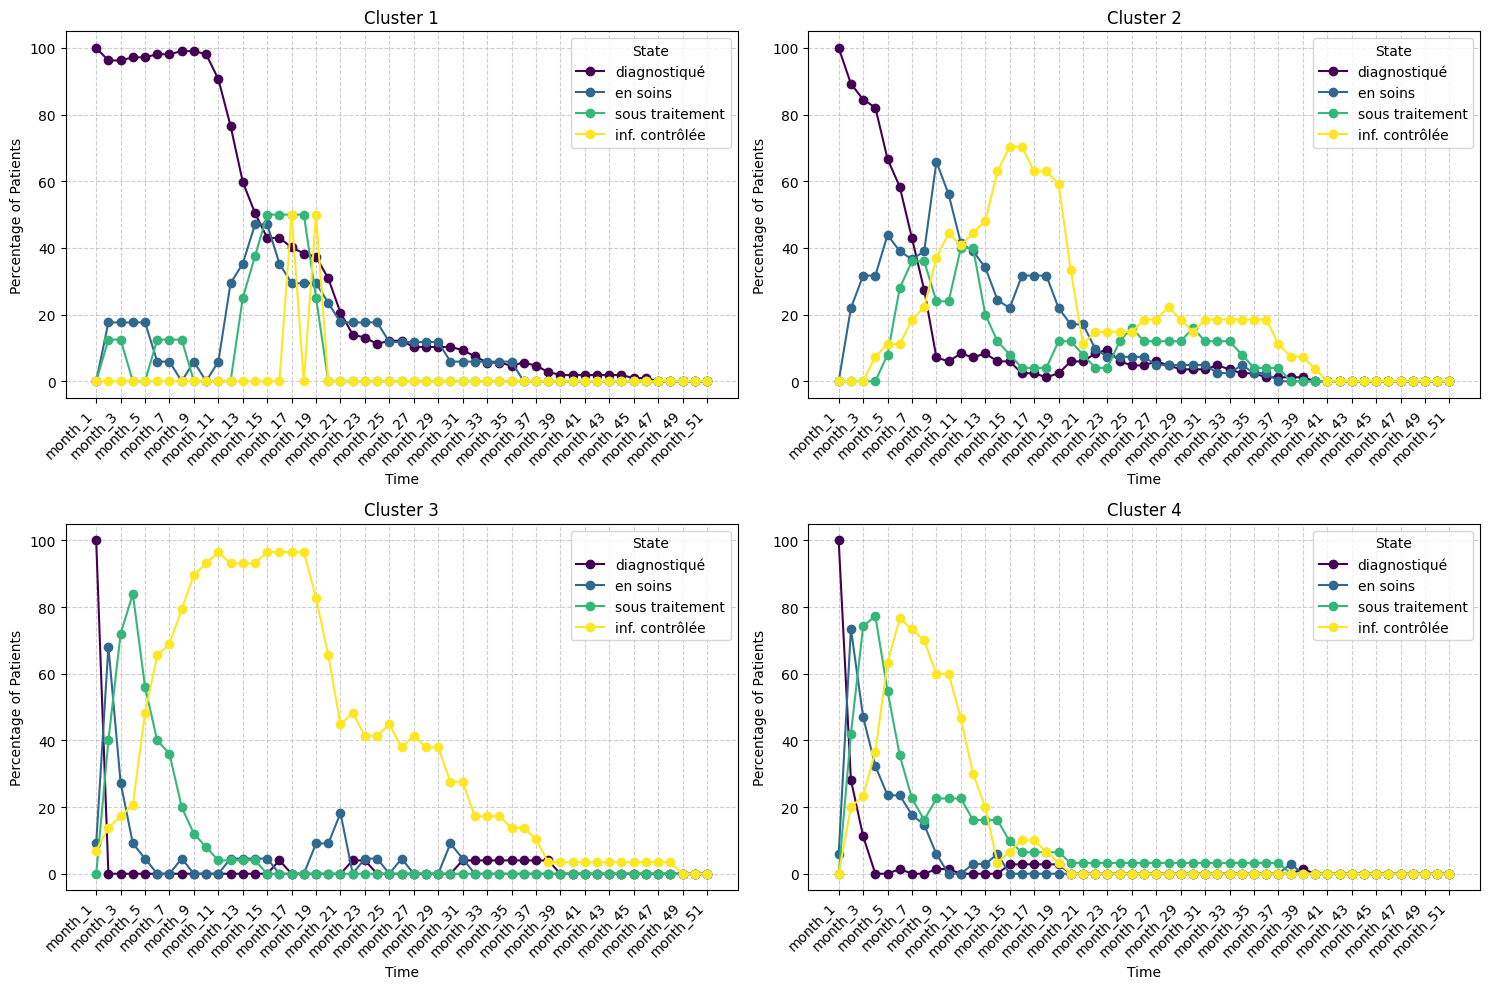

In [17]:
tca.plot_treatment_percentage(clusters=clusters)

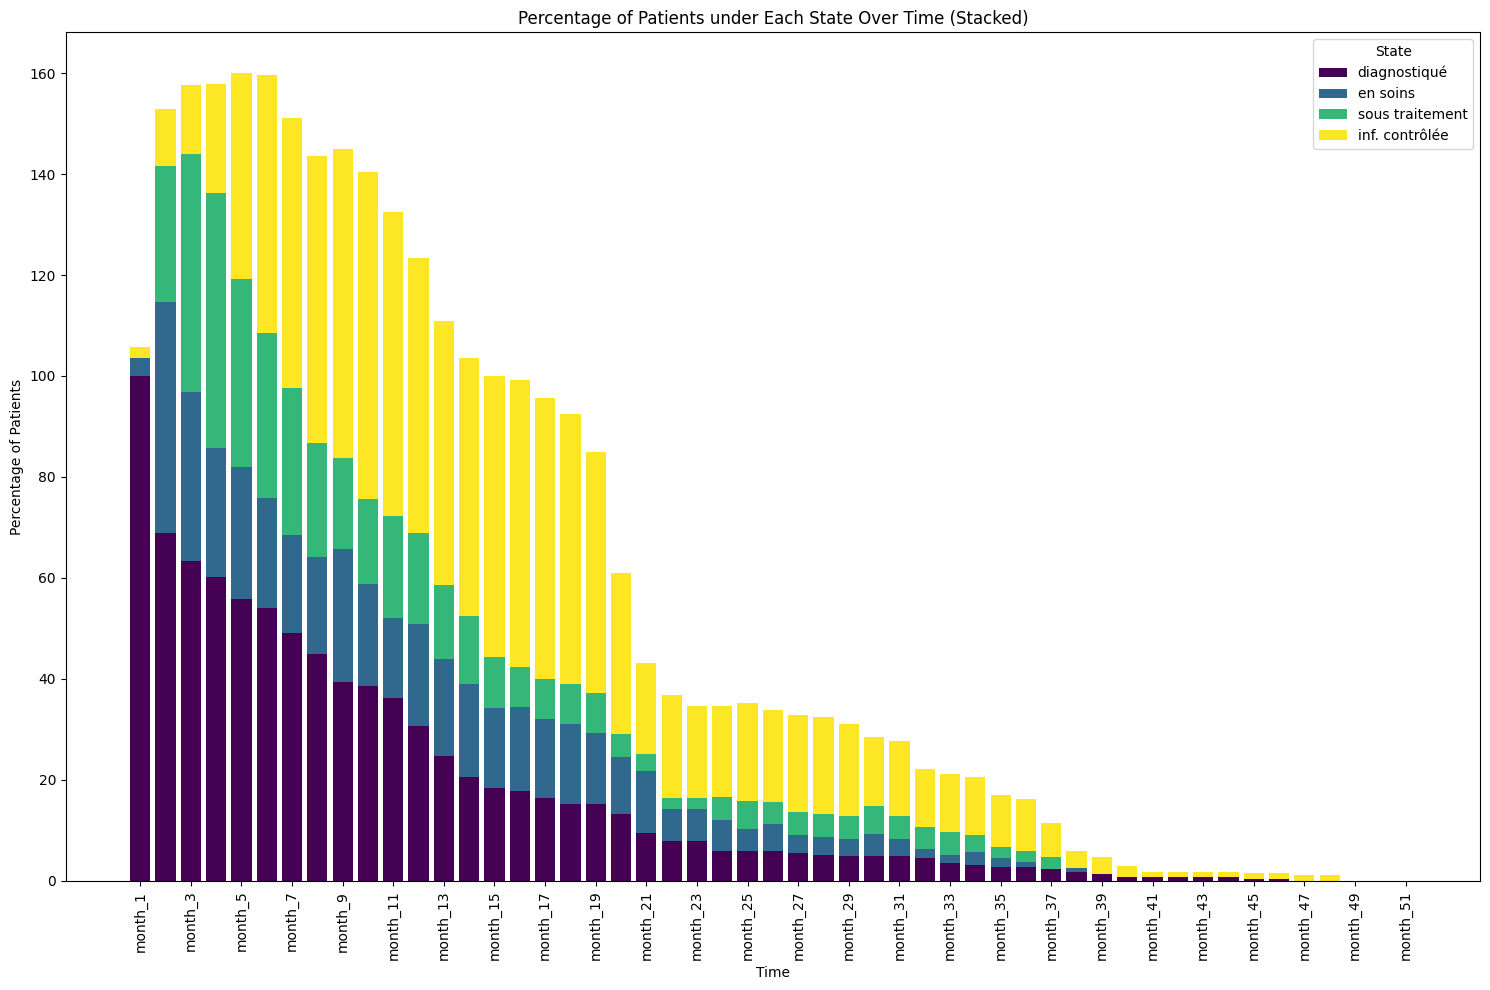

In [18]:

tca.bar_treatment_percentage()

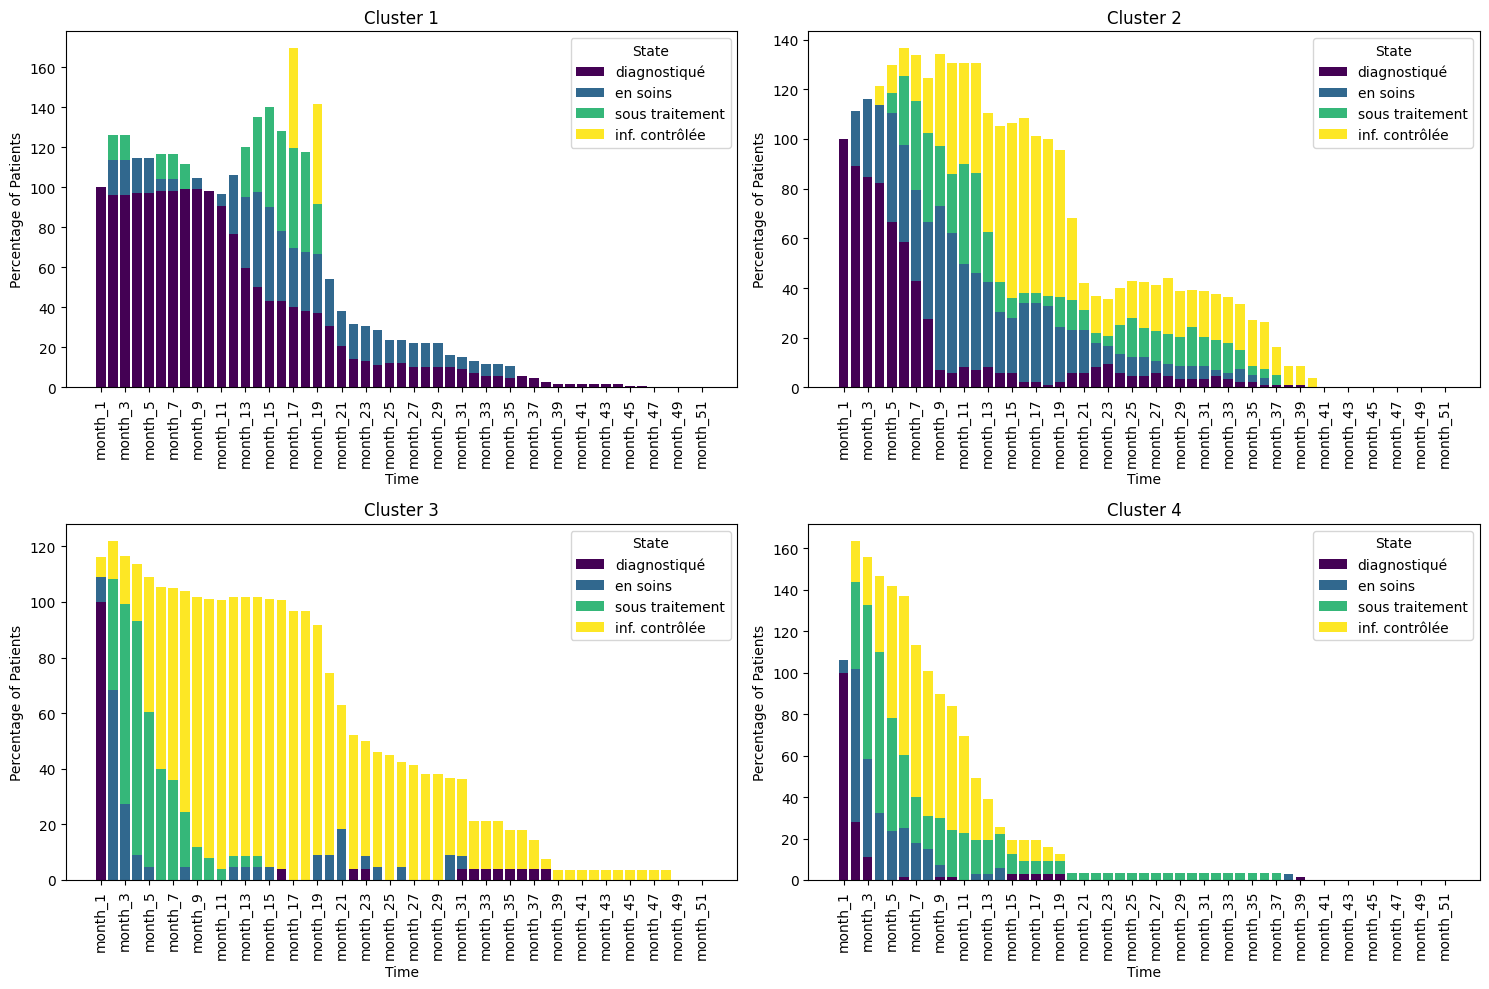

In [19]:
tca.bar_treatment_percentage(clusters=clusters)